In [8]:
import matplotlib.pyplot as plt
from typing import List, Dict
import numpy as np
import pandas as pd
import json
import os

In [9]:
DPI=300 # 300

In [10]:
root_directory = os.path.dirname("../")
logs_directory = os.path.join(root_directory, "logs")
current_dir = os.path.dirname(".")
plots_directory = os.path.join(current_dir, "plots")
# Logs to include in the analysis
logs_to_include = [
    "logs_2024-05-13T16:48:24",
    "logs_2024-05-13T17:10:19",
    "logs_2024-05-13T17:30:42",
    "logs_2024-05-13T17:51:08", 
    "logs_2024-05-13T18:11:28", 
    "logs_2024-05-13T18:50:33",
    "logs_2024-05-13T19:10:52",
    "logs_2024-05-13T19:31:13", 
    "logs_2024-05-13T21:24:43",
    "logs_2024-05-13T22:11:15",
    "logs_2024-05-13T22:57:41",
    "logs_2024-05-13T23:44:11", 
    "logs_2024-05-14T11:42:37"
] 

## Throughput

In [11]:
def get_throughput_paths_from_dir(directory: str) -> pd.DataFrame:
    """ Extracts throughput and paths from the logs in a directory

    :param directory: The directory containing the logs
    :type directory: str
    :return: Returns a DataFrame with columns: nb_paths, throughput, implementation
    :rtype: pd.DataFrame
    """
    result_json = {}
    # Assuming logs_directory is defined elsewhere in your code
    with open(os.path.join(logs_directory, directory, "result.json")) as f:
        result_json = json.load(f)
    
    df = pd.DataFrame(columns=["nb_paths", "goodput", "implementation"])
    data_to_append = [] # Initialize an empty list to store data before appending
    
    for measurement in result_json["measurements"]:
        for measurement_entry in measurement:
            if measurement_entry["name"] == "throughput":
                throughput_runs = measurement_entry["details"]
                filesize = measurement_entry["nb_paths"]
                implementation = measurement_entry["implementation"]
                
                # Assuming goodput_runs is a list of goodput values
                for throughput in throughput_runs:
                    # Instead of appending directly to the DataFrame, store the data in a list
                    data_to_append.append({"nb_paths": filesize, "throughput": throughput, "implementation": implementation})
    
    # Use pd.concat to append the data from the list to the DataFrame
    df = pd.concat([df, pd.DataFrame(data_to_append)], ignore_index=True)
    return df

def get_throughput_nb_paths(directories: List[str]) -> pd.DataFrame:
    df = pd.DataFrame(columns=["nb_paths", "throughput", "implementation"])
    for directory in directories:
        df_dir = get_throughput_paths_from_dir(directory)
        df = pd.concat([df, df_dir], ignore_index=True)
    df["nb_paths"] = df["nb_paths"].astype(int)
    df["throughput"] = df["throughput"].astype(float)
    return df


In [12]:
throughput_df = get_throughput_nb_paths(logs_to_include)

In [13]:
opt_throughput = get_throughput_nb_paths(["logs_2024-05-20T17:37:04"])
opt_throughput["implementation"] = "mcmpquic-HT"
throughput_df = pd.concat([throughput_df, opt_throughput], ignore_index=True)

In [14]:
import matplotlib.pyplot as plt
import pandas as pd

def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)        
    
def generate_offset(width: float, number: int) -> List[float]:
    """Generated offsets"""
    if number == 1:
        return [0]
    elif number == 2:
        return [(-1 * width / 1.8), width / 1.8]
    raise NotImplementedError("Implement it")
    # TODO generalize to more number and also odd number
    
def plot_throughput(ax: plt.Axes, df: pd.DataFrame):
    """ Plots the goodput data in a DataFrame. The expected DataFrame should have columns: nb_paths, throughput, implementation
    """
    implementations = sorted(list(df["implementation"].unique()), reverse=True)
    #colors = ["#0173B2", "#DE8F05", "#029E73", "#D55E00", "#CC78BC", "#CA9161", "#FBAFE4", "#949494", "#ECE133", "#56B4E9"]
    colors=["#0173B2", "#029E73", "#D55E00","#CC78BC", "#ECE133", "#56B4E9"]
    #colors = ["blue", "red"]
    all_nb_paths = list(df["nb_paths"].unique())
    all_nb_paths.sort()
    all_nb_paths = np.array(all_nb_paths)
    next_index = 0
    max_observed = 0
    box_width = 0.2
    offsets = generate_offset(box_width, len(implementations))
    one_path = 0
    for implementation in implementations:
        df_impl = df[df["implementation"] == implementation]
        subboxplot_data = []
        for nb_paths in all_nb_paths:
            throughput_values = df_impl[df_impl["nb_paths"] == nb_paths]["throughput"]
            throughput_values = throughput_values.to_numpy()
            subboxplot_data.append(throughput_values)
            if len(throughput_values) == 0: continue
            if nb_paths == 1:
                one_path = np.mean(throughput_values)
            max_observed = max(max_observed, max(throughput_values))
            print("path: ", nb_paths, "implementation: ", implementation, "avg: ", np.mean(throughput_values), "speedup: ", np.mean(throughput_values) / one_path)
        bxp = ax.boxplot(subboxplot_data, positions=all_nb_paths + offsets[next_index], widths=box_width)
        set_box_color(bxp, colors[next_index])
        next_index += 1
    
    ax.set_xticks(all_nb_paths, all_nb_paths)
    ax.set_xlabel("Number of paths")
    ax.set_ylabel("Throughput [Mbps]")
    ax.grid(which='major', color='black', linewidth=1, alpha=0.3, linestyle="dashed") # Show the major grid
    ax.grid(which='minor', axis="y", color='black', linewidth=0.6, alpha=0.3, linestyle="dotted") # Show the major grid
    ax.set_ylim(0, max_observed * 1.02)
    
    for i in range(next_index):
        ax.plot([], c=colors[i], label=implementations[i])
    ax.legend()    
    ax.minorticks_on() # Make the minor ticks and gridlines show
    ax.tick_params(axis='x', which='minor', bottom=False) # Disable the minor ticks on the x-axis

/tmp/ipykernel_35534/2885208758.py:45: RuntimeWarning: divide by zero encountered in double_scalars
  print("path: ", nb_paths, "implementation: ", implementation, "avg: ", np.mean(throughput_values), "speedup: ", np.mean(throughput_values) / one_path)


path:  10 implementation:  mcmpquic-HT avg:  21846.203070289863 speedup:  inf
path:  11 implementation:  mcmpquic-HT avg:  20501.980218013498 speedup:  inf
path:  12 implementation:  mcmpquic-HT avg:  20773.15989929494 speedup:  inf
path:  13 implementation:  mcmpquic-HT avg:  19974.499188292964 speedup:  inf
path:  1 implementation:  mcmpquic avg:  3287.9668311969954 speedup:  1.0
path:  2 implementation:  mcmpquic avg:  6417.868174923126 speedup:  1.9519260699435583
path:  3 implementation:  mcmpquic avg:  8623.469957049183 speedup:  2.622736298683944
path:  4 implementation:  mcmpquic avg:  11133.545802519817 speedup:  3.3861490623573633
path:  5 implementation:  mcmpquic avg:  13329.403896012529 speedup:  4.053995852251318
path:  6 implementation:  mcmpquic avg:  15700.312907519354 speedup:  4.775082509516558
path:  7 implementation:  mcmpquic avg:  17951.660391776437 speedup:  5.459805805048549
path:  8 implementation:  mcmpquic avg:  20439.55818670249 speedup:  6.216473351484935


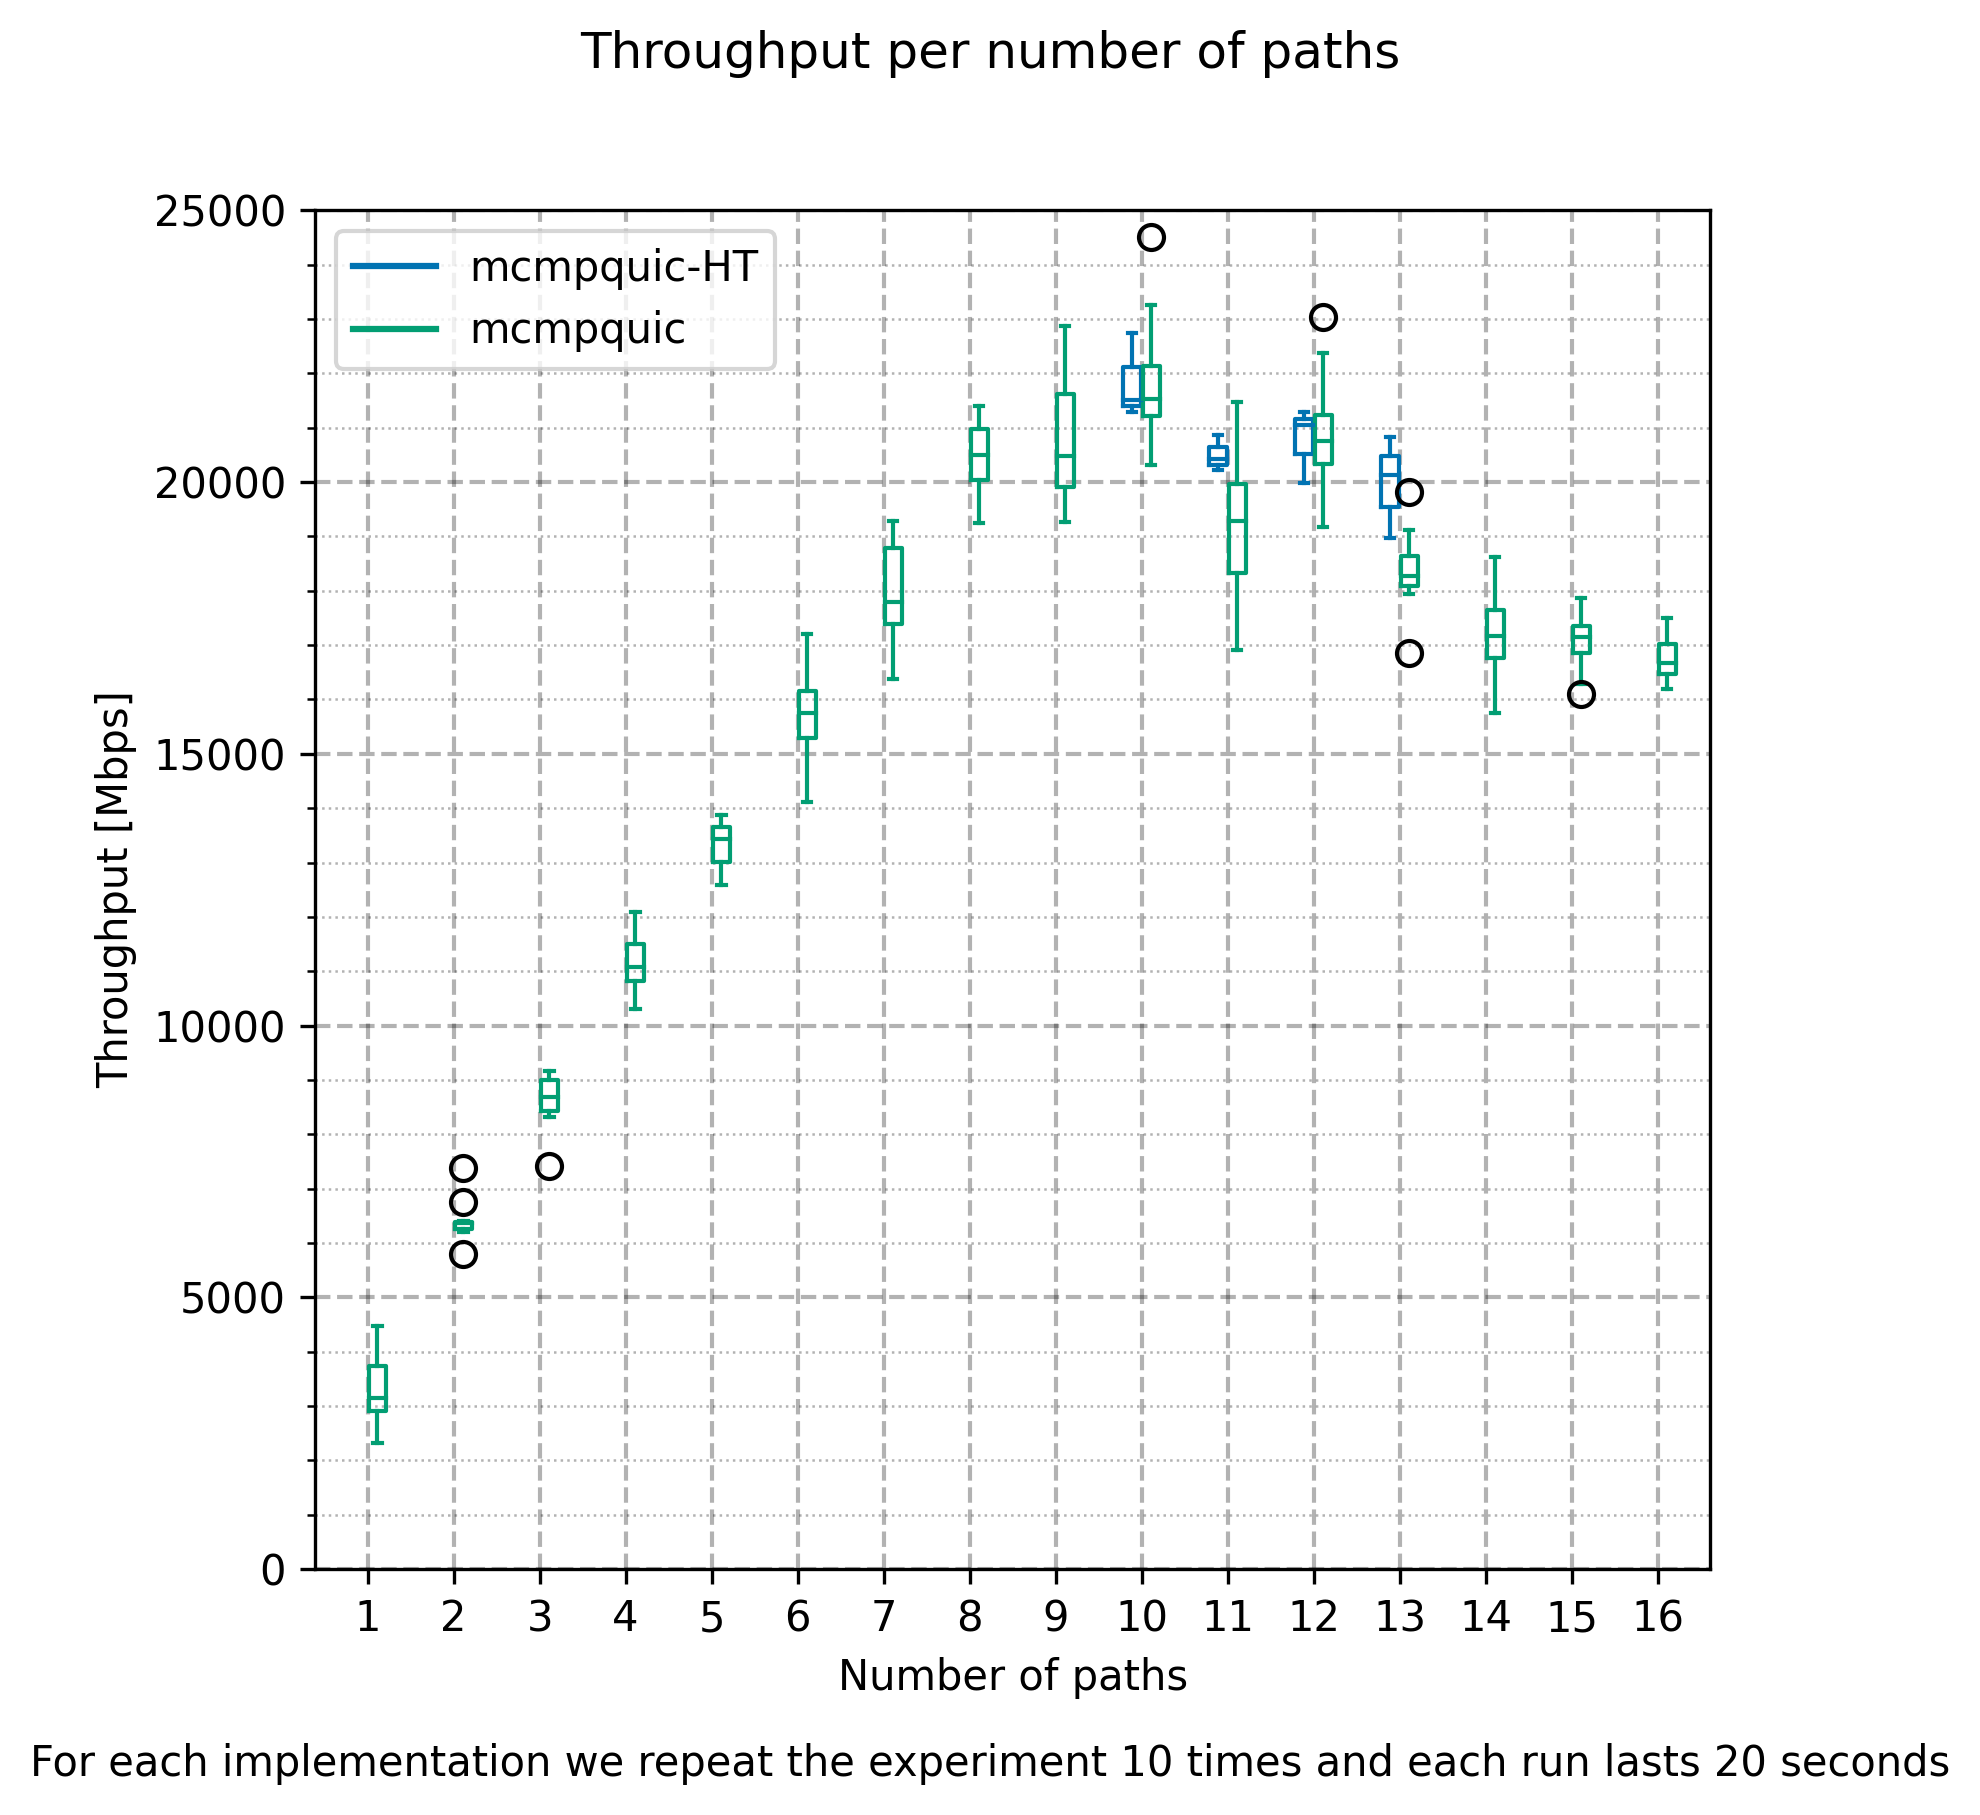

In [15]:
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(6, 6), dpi=DPI)
fig.suptitle("Throughput per number of paths")
plot_throughput(ax, throughput_df.copy())
#ax.set_title("Throughput of the differ ent implementations on the cloudlab testbed")
fig.text(.5, .01, "For each implementation we repeat the experiment 10 times and each run lasts 20 seconds", ha='center')
plt.savefig(os.path.join(plots_directory, "throughput_nb_paths_impl_boxplot_120.pdf"), format="pdf", bbox_inches="tight")
plt.savefig(os.path.join(plots_directory, "throughput_nb_paths_impl_boxplot_120.svg"), format="svg", bbox_inches="tight")
plt.show()